# Notes sur les plots:
- Grosse différence des arrets aux niveaux des hispaniques : les policiers hispaniques arretent en moyenne beaucoup plus les hispaniques.
- Les medianes sont perturbantes : sur le dataset ne gardant qu'une entrée par année pour les policiers, plus de la moitié des blancs n'arrêtent pas d'hispaniques
- Il semble que les policiers ont tendance à arreter leur ethnie plus que les autres arrêtent cette ethnie en moyenne, et en médiane.
- Il semble que les femmes arretent moins les femmes en médiane. (mais pas en moyenne)
- Il ne semble pas y avoir de différence notable entre les pourcentages ethniques des arrets des hommes et des femmes en moyenne/mediane. <br/>

Rq : il y a 90% d'hommes dans le dataset

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
%load_ext autoreload
%autoreload 2

In [2]:
folder = './data/'
state = 'fl_statewide.csv.zip'
state_cut = 'fl_statewide_cut.csv'
state2 = 'ca_long_beach.csv.zip'

In [3]:
california = pd.read_csv(folder + state2)
florida = pd.read_csv(folder + state_cut)

For now let's just work with the reduced florida dataset.

Environ 350 stops par officier en moyenne.

In [4]:
def create_year_hash(df):
    df['year'] = df.date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').year)
    df['officer_hash_year'] = df['officer_id_hash'] + '-' + df['year'].astype(str)

In [5]:
create_year_hash(florida)

In [89]:
def mean_stop(df, param, column):
    return (df[column] == param).mean()

In [157]:
def bias_score_officer(df, percent_b, percent_w, percent_l):
    colors = ['black', 'white', 'hispanic']
    var = [df['percent_black'].std(), df['percent_white'].std(), df['percent_hispanic'].std()]
    variances = dict(zip(colors, var))
    means = dict(zip(colors, [percent_b, percent_w, percent_l]))
    bias_score = np.zeros(len(df))
    for color in colors:
        bias_score += ((df['percent_' + color] - means[color])/variances[color]).values
    bias_score = (bias_score - bias_score.mean())/bias_score.std()
    return bias_score

In [90]:
officer_table_florida = pd.DataFrame(index = florida.officer_hash_year.unique())

In [91]:
colors = ['black', 'white', 'hispanic']
sexes = ['male', 'female']

for color in colors:
    officer_table_florida['percent_' + color] = florida.groupby('officer_hash_year').apply(mean_stop, param = color, column = 'subject_race')

for sex in sexes:
    officer_table_florida['percent_' + sex] = florida.groupby('officer_hash_year').apply(mean_stop, param = sex, column = 'subject_sex')


In [159]:
df = florida
percent_b, percent_w, percent_l = (df.subject_race == 'black').mean(), (df.subject_race == 'white').mean(), (df.subject_race == 'hispanic').mean()
officer_table_florida['bias_score'] = bias_score_officer(officer_table_florida, percent_b, percent_w, percent_l)

In [160]:
officer_table_florida.bias_score.describe()

count    1.302800e+04
mean     4.908570e-18
std      1.000038e+00
min     -6.330303e+00
25%     -3.509349e-01
50%      7.104979e-02
75%      6.233712e-01
max      1.758988e+00
Name: bias_score, dtype: float64

In [9]:
officer_columns = ['officer_race', 'officer_age', 'officer_sex', 'officer_years_of_service', 'officer_hash_year']

### We have many nan values regarding the officer information, up to 43% for the officer race

In [92]:
complete_officer_df_florida = florida[officer_columns].dropna().drop_duplicates().set_index('officer_hash_year').join(officer_table_florida)

In [101]:
percents = ['percent_black', 'percent_white', 'percent_hispanic']
means = {}
for color in colors:
    means[color] = complete_officer_df_florida.loc[complete_officer_df_florida['officer_race'] == color, percents].median()

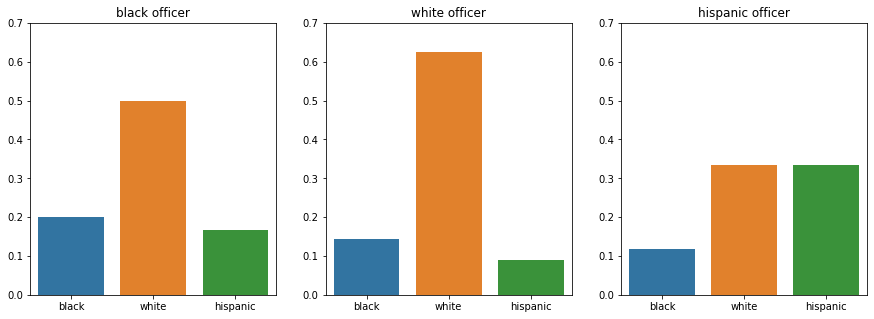

In [102]:
plt.figure(figsize=(15,5))
for i, color in enumerate(colors):
    plt.subplot(1,3,i+1)
    axs = sns.barplot(x = colors, y = means[color])
    axs.set_ylim(0, 0.7)
    plt.title(color + ' officer')
plt.show()

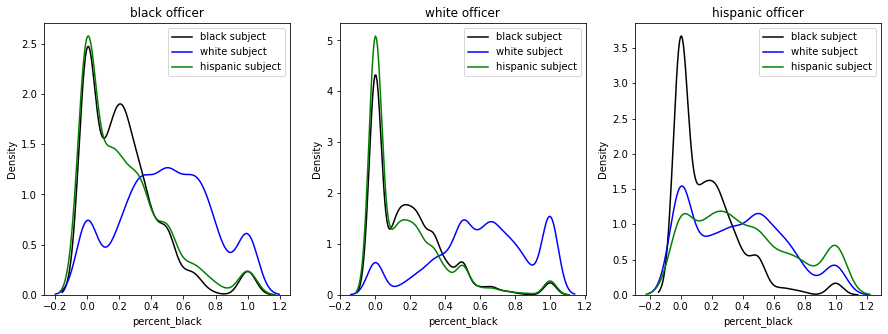

In [308]:
c= dict(zip(colors, ['k', 'b', 'g']))
plt.figure(figsize=(15,5))
for i, cop_color in enumerate(colors):
    axs = plt.subplot(1,3,i+1)
    for color in colors:
        sns.kdeplot(complete_officer_df_florida.loc[complete_officer_df_florida['officer_race'] == cop_color, 'percent_' + color], ax = axs, color = c[color], label = color + ' subject')
        plt.legend()
    plt.title(cop_color + ' officer')
plt.show()

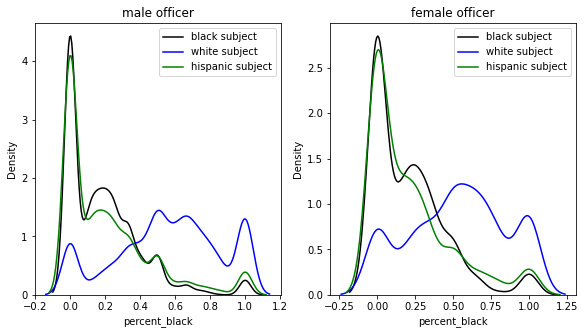

In [32]:
c= dict(zip(colors, ['k', 'b', 'g']))
plt.figure(figsize=(15,5))
for i, cop_sex in enumerate(['male', 'female']):
    axs = plt.subplot(1,3,i+1)
    for color in colors:
        sns.kdeplot(complete_officer_df_florida.loc[complete_officer_df_florida['officer_sex'] == cop_sex, 'percent_' + color], ax = axs, color = c[color], label = color + ' subject')
        plt.legend()
    plt.title(cop_sex + ' officer')
plt.show()

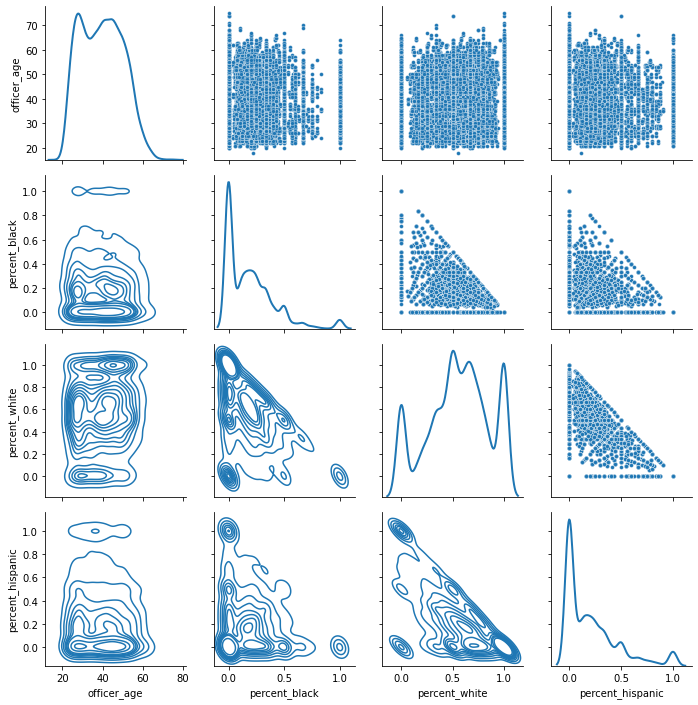

In [29]:
g = sns.PairGrid(complete_officer_df_florida[['officer_age'] + percents], diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

In [93]:
clearer_df = pd.DataFrame(columns=complete_officer_df_florida.columns)

In [94]:
for index in complete_officer_df_florida.index.drop_duplicates():
    if (len(complete_officer_df_florida.loc[index].shape) > 1):
        clearer_df.loc[index] = complete_officer_df_florida.loc[index].iloc[0]
    else:
        clearer_df.loc[index] = complete_officer_df_florida.loc[index]

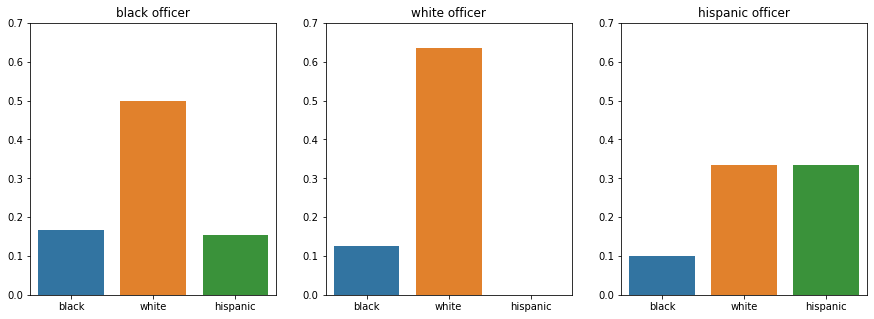

In [100]:
percents = ['percent_black', 'percent_white', 'percent_hispanic']
means = {}
for color in colors:
    means[color] = clearer_df.loc[clearer_df['officer_race'] == color, percents].median()

plt.figure(figsize=(15,5))
for i, color in enumerate(colors):
    plt.subplot(1,3,i+1)
    axs = sns.barplot(x = colors, y = means[color])
    axs.set_ylim(0, 0.7)
    plt.title(color + ' officer')
plt.show()

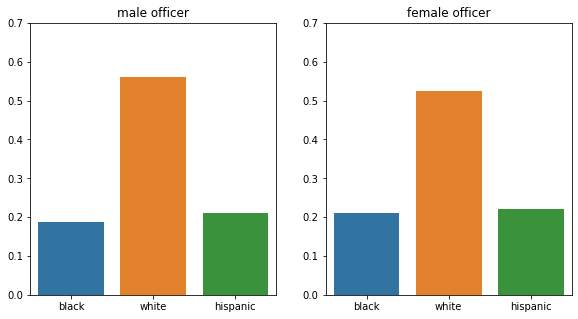

In [105]:
percents = ['percent_black', 'percent_white', 'percent_hispanic']
means = {}
for sex in sexes:
    means[sex] = clearer_df.loc[clearer_df['officer_sex'] == sex, percents].mean()

plt.figure(figsize=(15,5))
for i, sex in enumerate(sexes):
    plt.subplot(1,3,i+1)
    axs = sns.barplot(x = colors, y = means[sex])
    axs.set_ylim(0, 0.7)
    plt.title(sex + ' officer')
plt.show()

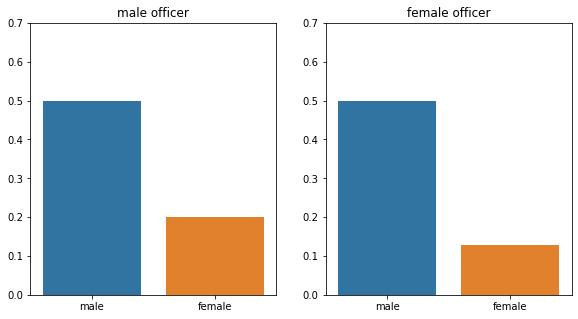

In [104]:
percents = ['percent_male', 'percent_female']
means = {}
for sex in sexes:
    means[sex] = clearer_df.loc[clearer_df['officer_sex'] == sex, percents].median()

plt.figure(figsize=(15,5))
for i, sex in enumerate(sexes):
    plt.subplot(1,3,i+1)
    axs = sns.barplot(x = sexes, y = means[sex])
    axs.set_ylim(0, 0.7)
    plt.title(sex + ' officer')
plt.show()

In [143]:
clearer_df[clearer_df['officer_age'].isin(age)][percents].mean()

percent_black       0.199486
percent_white       0.542606
percent_hispanic    0.214679
dtype: float64

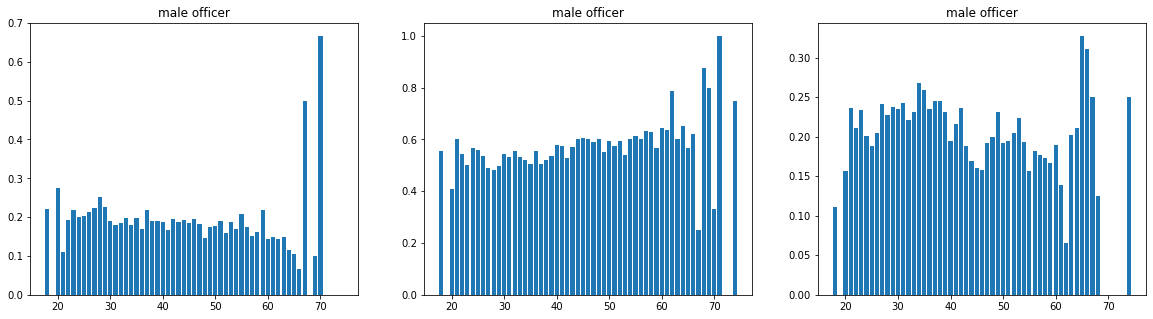

In [157]:
ages = clearer_df.officer_age.unique()
percents = ['percent_black', 'percent_white', 'percent_hispanic']
means = {}
for age in ages:
    means[age] = clearer_df.loc[clearer_df['officer_age'] == age, percents].mean()

plt.figure(figsize=(20,5))
for i, color in enumerate(colors):
    plt.subplot(1,3,i+1)
    axs = plt.bar(ages,[means[age]['percent_' + color] for age in ages])
    plt.title(sex + ' officer')
plt.show()

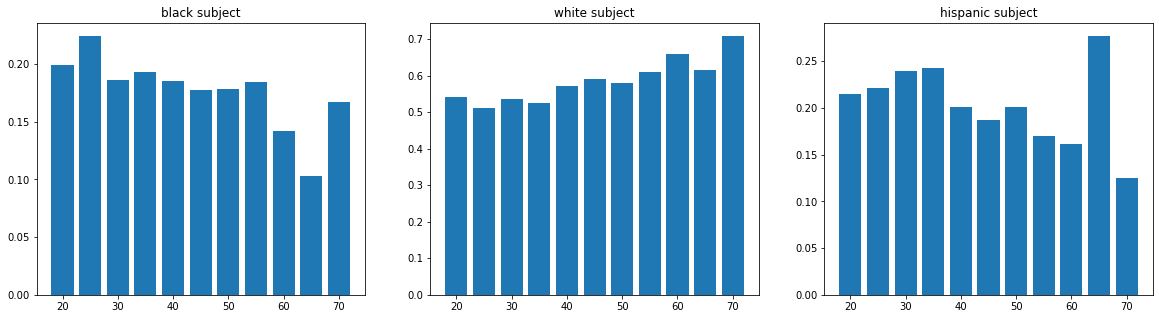

In [163]:
ages = [np.arange(20.0 + 5*i, 20.0 + 5 *(i+1)) for i in range(11)]
percents = ['percent_black', 'percent_white', 'percent_hispanic']
means = {}
for age in ages:
    means[age[0]] = clearer_df[clearer_df['officer_age'].isin(age)][percents].mean()

plt.figure(figsize=(20,5))
for i, color in enumerate(colors):
    plt.subplot(1,3,i+1)
    axs = plt.bar(means.keys(), [means[age[0]]['percent_' + color] for age in ages], width=4)
    plt.title(color + ' subject')
plt.show()

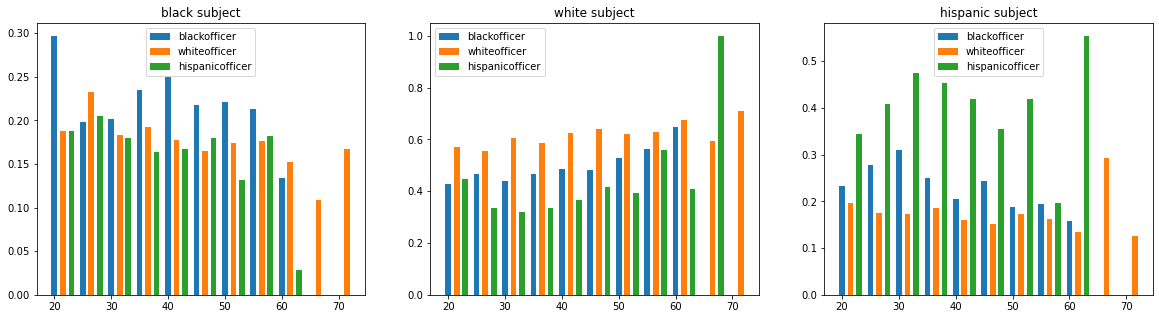

In [191]:
ages = [np.arange(20.0 + 5*i, 20.0 + 5 *(i+1)) for i in range(11)]
percents = ['percent_black', 'percent_white', 'percent_hispanic']

means = dict(zip(colors, [{}, {}, {}]))
for color in colors:
    for age in ages:
        means[color][age[0]] = clearer_df[clearer_df['officer_age'].isin(age) & (clearer_df['officer_race'] == color)][percents].mean()

plt.figure(figsize=(20,5))
for i, color in enumerate(colors):
    plt.subplot(1,3,i+1)
    for j, officer_color in enumerate(colors):
        axs = plt.bar(np.array(list(means[officer_color].keys())) + j*1.5, [means[officer_color][age[0]]['percent_' + color] for age in ages], label = officer_color + "officer", width=1)
    plt.legend()
    plt.title(color + ' subject')
plt.show()